0.000781638583424 arcsec
33.8343367292 d


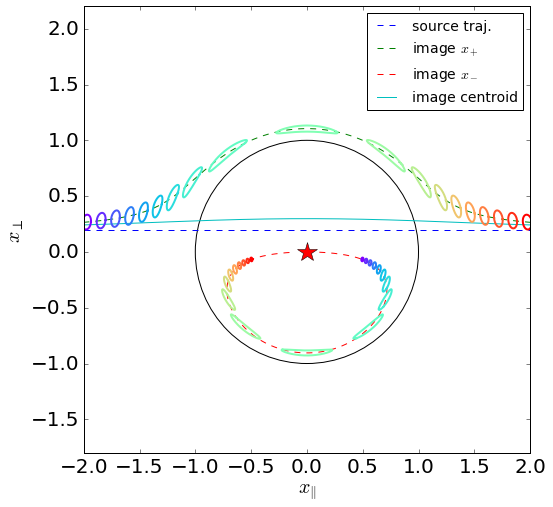

In [93]:
import numpy as np
from astropy import constants as const
from astropy import units as u
import matplotlib.pyplot as plt

class point_source(object):
    
    def __init__(self,flux=1.0,ds=10.0,vel=200.):
        self.ds=ds
        self.flux=flux
        self.vel=vel
        

class point_lens(object):

    
    def __init__(self,ps,mass=1.0,dl=5.0,ds=8.0,t0=0.0,y0=0.1):
        self.M=mass
        self.dl=dl
        self.ps=ps
        self.y0=y0
        self.t0=t0
        self.tE=self.EinsteinCrossTime()
        
    def EinsteinRadius(self):
        mass=self.M*const.M_sun
        G=const.G
        c=c=const.c
        aconv=180.0*3600.0/np.pi*u.arcsecond
        return((np.sqrt(4.0*(G*mass/c/c).to('kpc')*(self.ps.ds-self.dl)
                        /self.dl/self.ps.ds/u.kpc))*aconv)
    
    def EinsteinCrossTime(self):
        theta_e=self.EinsteinRadius()
        return(((theta_e.to('radian').value*self.dl*u.kpc).to('km')
                /self.ps.vel/u.km*u.s).to('day'))
    
    def y(self,t):
        y1=(t-self.t0)/self.tE.value
        y2=np.ones(len(t))*self.y0
        return(y1,y2)
    
    def xp(self,t):
        y1,y2=self.y(t)
        Q=np.sqrt(y1**2+y2**2+4.0)/np.sqrt(y1**2+y2**2)
        xp1=0.5*(y1+Q*y1)
        xp2=0.5*(y2+Q*y2)
        return(xp1,xp2)
    
    def xm(self,t):
        y1,y2=self.y(t)
        Q=np.sqrt(y1**2+y2**2+4.0)/np.sqrt(y1**2+y2**2)
        xp1=0.5*(y1-Q*y1)
        xp2=0.5*(y2-Q*y2)
        return(xp1,xp2)
    
    def mup(self,t):
        y1,y2=self.y(t)
        y=np.sqrt(y1**2+y2**2)
        return (+(y+np.sqrt(y**2+4.0))**2/4.0/y/np.sqrt(y**2+4))
    
    def mum(self,t):
        y1,y2=self.y(t)
        y=np.sqrt(y1**2+y2**2)
        return (-(y-np.sqrt(y**2+4.0))**2/4.0/y/np.sqrt(y**2+4))
    
    def mu(self,f):
        y1,y2=self.y(t)
        y=np.sqrt(y1**2+y2**2)
        return((y**2+2)/(y*np.sqrt(y**2+4)))
    
    def xc(self,t):
        xp=self.xp(t)
        xm=self.xm(t)
        mp=np.abs(self.mup(t))
        mm=np.abs(self.mum(t))
        xc=(xp*mp+xm*mm)/(mp+mm)
        return(xc)
    
    def deltaxc(self,t):
        y1,y2=self.y(t)
        yy=(y1**2+y2**2)
        return(y1/(yy+2),y2/(yy+2))
    
    def xp_ext_source(self,t,r):
        phi=np.linspace(0.0,2*np.pi,360)
        dy1=r*np.cos(phi)
        dy2=r*np.sin(phi)
        y1,y2=self.y(t)
        yy1=y1+dy1
        yy2=y2+dy2
        Q=np.sqrt(yy1**2+yy2**2+4.0)/np.sqrt(yy1**2+yy2**2)
        xp1=0.5*(1+Q)*yy1
        xp2=0.5*(1+Q)*yy2
        return(xp1,xp2)   
    
    def xm_ext_source(self,t,r):
        phi=np.linspace(0.0,2*np.pi,360)
        dy1=r*np.cos(phi)
        dy2=r*np.sin(phi)
        y1,y2=self.y(t)
        yy1=y1+dy1
        yy2=y2+dy2
        Q=np.sqrt(yy1**2+yy2**2+4.0)/np.sqrt(yy1**2+yy2**2)
        xm1=0.5*(1-Q)*yy1
        xm2=0.5*(1-Q)*yy2
        return(xm1,xm2)    
        
        
        
ps=point_source(flux=1.0,ds=8.0)
pl=point_lens(ps=ps,mass=1.0,dl=5.0,y0=0.2)

t=np.linspace(-300,300,2000)
y1,y2=pl.y(t)
xp1,xp2=pl.xp(t)
xm1,xm2=pl.xm(t)
xc1,xc2=pl.xc(t)


%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(y1,y2,'--',label='source traj.')
ax.plot(xp1,xp2,'--',label='image $x_+$')
ax.plot(xm1,xm2,'--',label='image $x_-$')
ax.plot(xc1,xc2,label='image centroid')


t_sparse=np.linspace(-50,50,19)
from matplotlib.pyplot import cm 
color=iter(cm.rainbow(np.linspace(0,1,t_sparse.size)))
for tt in t_sparse:
    c=next(color)
    xp1_e,xp2_e=pl.xp_ext_source(np.array([tt]),0.05)
    ax.plot(xp1_e,xp2_e,color=c,lw=2)
    xm1_e,xm2_e=pl.xm_ext_source(np.array([tt]),0.05)
    ax.plot(xm1_e,xm2_e,color=c,lw=2)
    
ax.set_xlim([-2,2])
ax.set_ylim([-1.8,2.2])
ax.plot([0.0],[0.0],'*',markersize=20,color='red')
circle=plt.Circle((0,0),1,color='black',fill=False)
ax.add_artist(circle)
ax.legend(fontsize=14)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlabel(r'$x_\|$',fontsize=20)
ax.set_ylabel(r'$x_\perp$',fontsize=20)

fig.savefi

print pl.EinsteinRadius()
print pl.EinsteinCrossTime()
        

In [ ]:
mup=pl.mup(t)
mum=pl.mum(t)
mu=pl.mu(t)

dxc1,dxc2=pl.deltaxc(t)
plt.plot(dxc1*pl.EinsteinRadius(),dxc2*pl.EinsteinRadius())
#plt.yscale('log')



